<a href="https://colab.research.google.com/github/nour-said/music-classification/blob/main/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
import librosa
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = "/content/drive/MyDrive/Data.zip"
extraction_dir = "/content/extracted_data"

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Data extracted to: {extraction_dir}")

Data extracted to: /content/extracted_data


In [4]:
DATASET_PATH = "/content/extracted_data/genres_original"

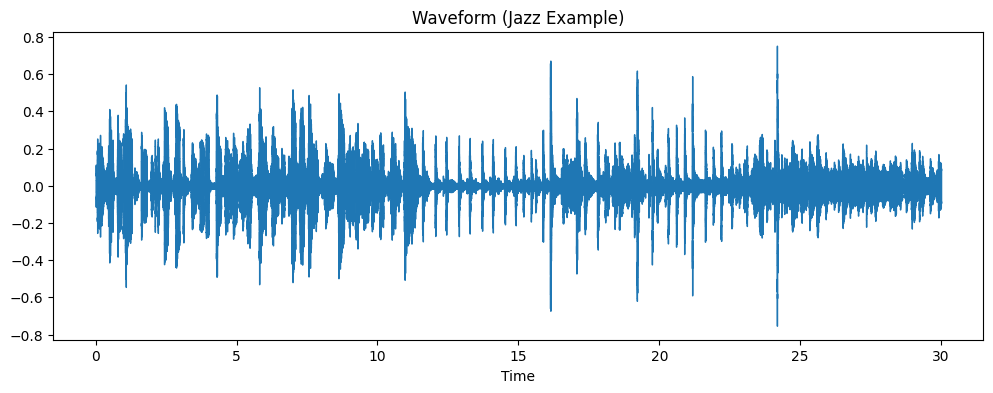

In [5]:
sample_file = os.path.join(DATASET_PATH, "jazz", os.listdir(os.path.join(DATASET_PATH,"jazz"))[0])

y, sr = librosa.load(sample_file, duration=30)

plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform (Jazz Example)")
plt.show()

In [6]:
y.shape


(661500,)

In [7]:
from IPython.display import Audio
Audio(data=y,rate=sr)

In [8]:
y


array([-0.01733398, -0.02090454, -0.01681519, ..., -0.03890991,
       -0.04098511, -0.0440979 ], dtype=float32)

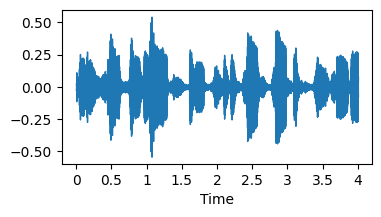

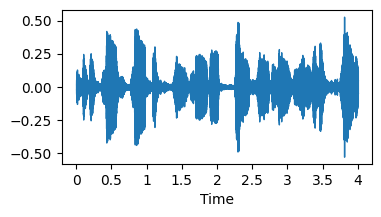

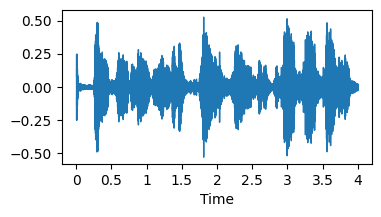

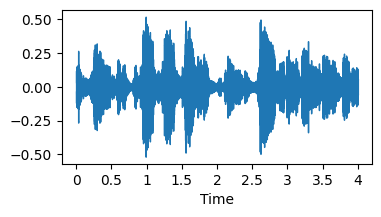

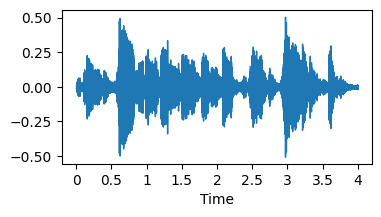

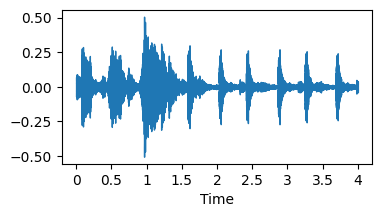

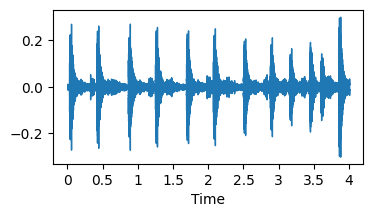

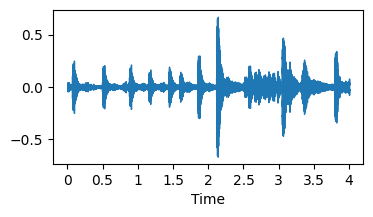

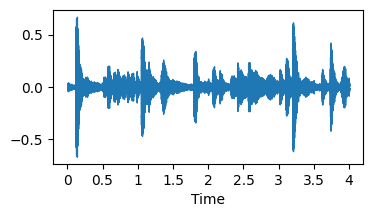

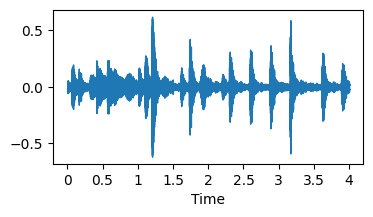

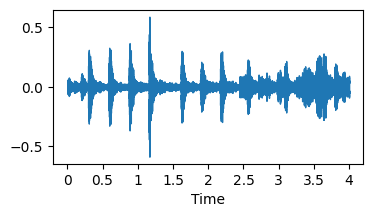

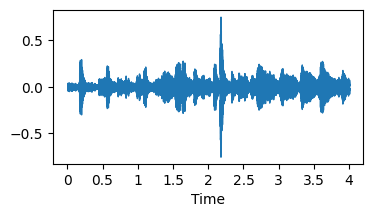

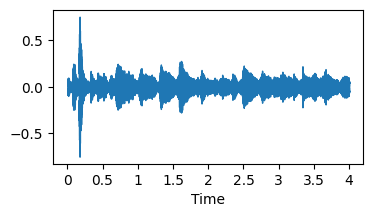

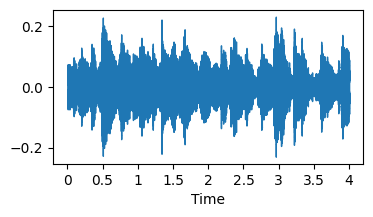

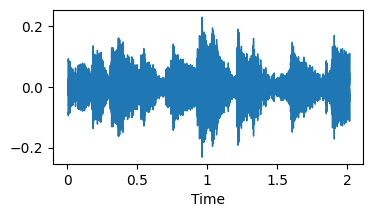

In [9]:
audio_path = sample_file
y, sr = librosa.load(audio_path, sr=None)  # sr=None to keep the original sampling rate

chunk_duration = 4
overlap_duration = 2

# Convert durations to samples
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr


num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

# Iterate over each chunk
for i in range(num_chunks):

    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples

    # Extract the chunk of audio
    chunk = y[start:end]
    plt.figure(figsize=(4, 2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()


In [10]:
#Plotting Melspectrogram of Entire Audio
def plot_melespectrogram(y,sr):

    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)
    #Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
    #Visualize the spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()


In [11]:
y,sr = librosa.load(sample_file,sr=44100)

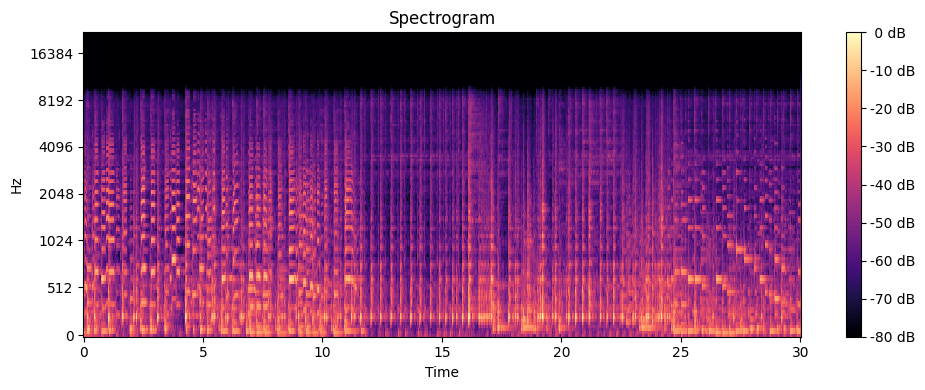

In [12]:

plot_melespectrogram(y,sr)


In [13]:
def plot_melspectrogram_chunks(y,sr):

    chunk_duration = 4
    overlap_duration = 2

    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    #Calculate the number of chunks
    num_chunks = int(np.ceil((len(y)-chunk_samples)/(chunk_samples-overlap_samples)))+1

    #iterate over each chunks
    for i in range(num_chunks):
        start = i*(chunk_samples-overlap_samples)
        end = start+chunk_samples
        chunk = y[start:end]
        spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        print(spectrogram.shape)
        spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)

        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()
        plt.show()

In [14]:
random_file_name = sample_file
y,sr = librosa.load(random_file_name,sr=44100)

(128, 345)


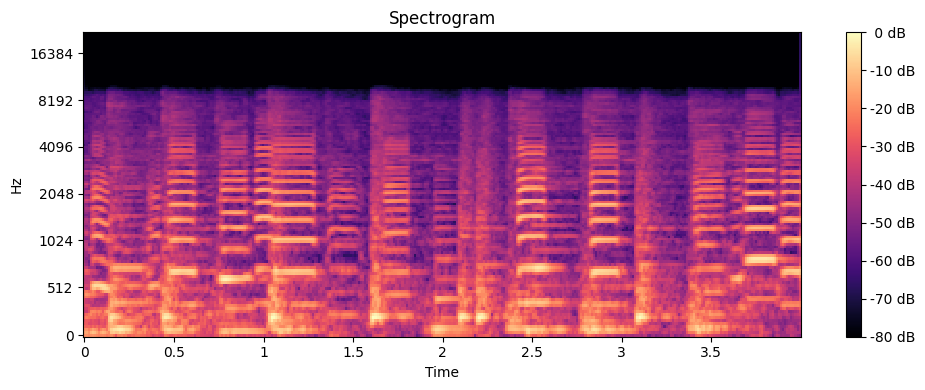

(128, 345)


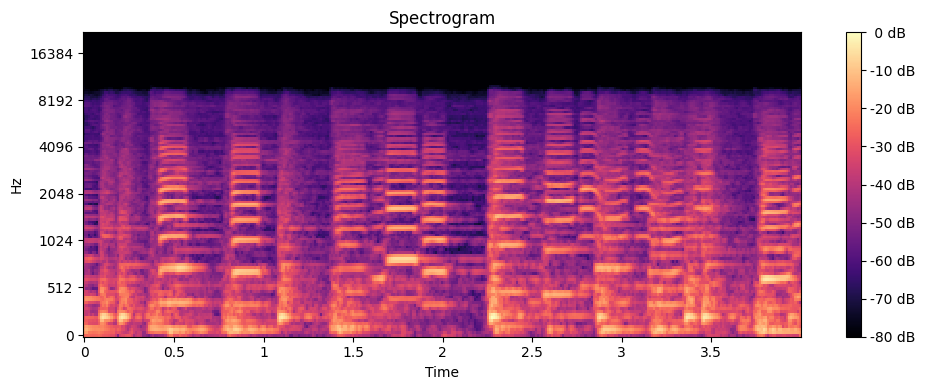

(128, 345)


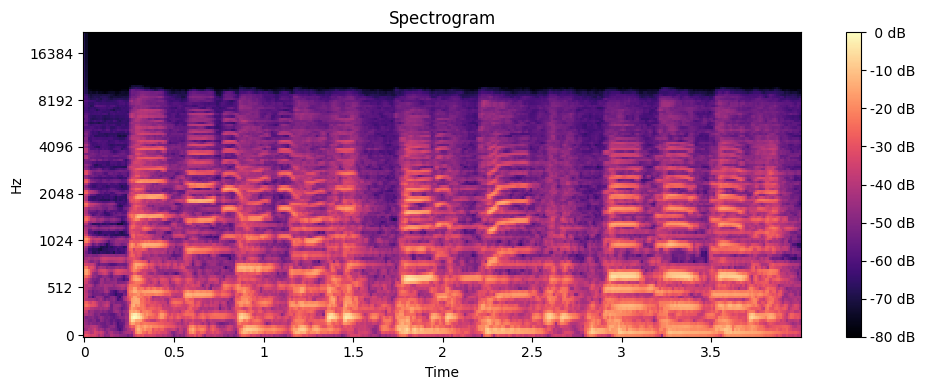

(128, 345)


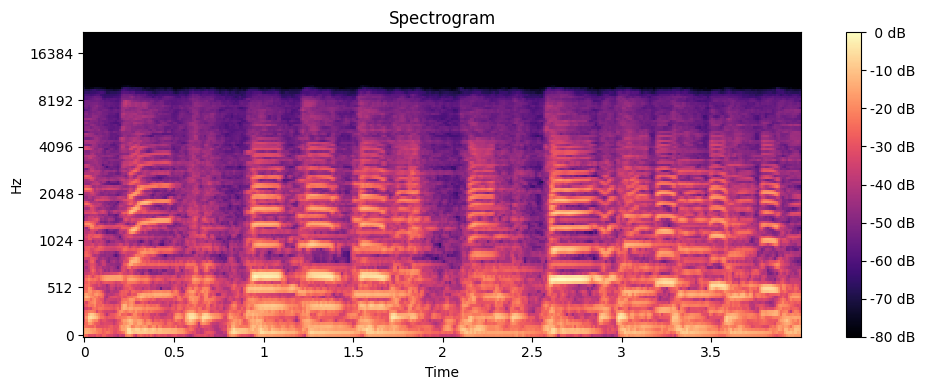

(128, 345)


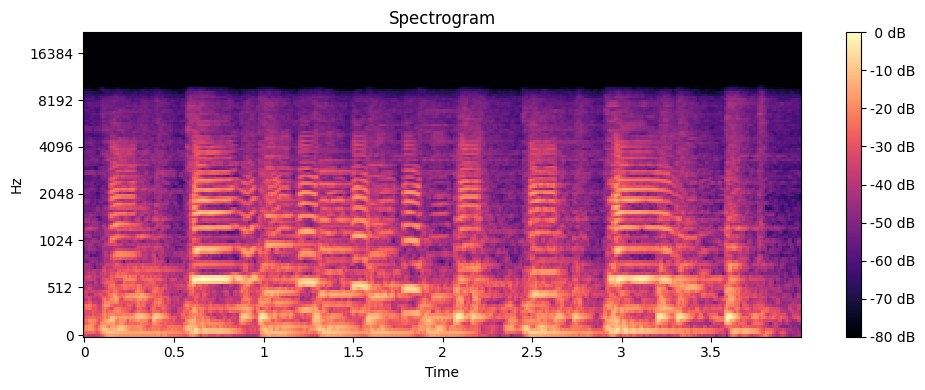

(128, 345)


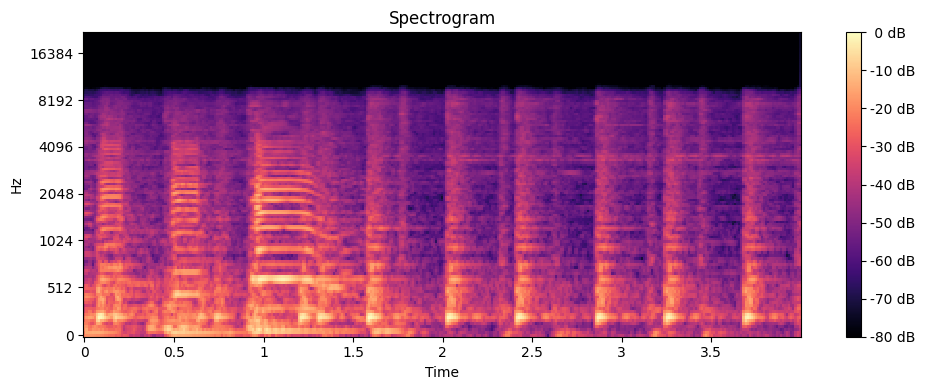

(128, 345)


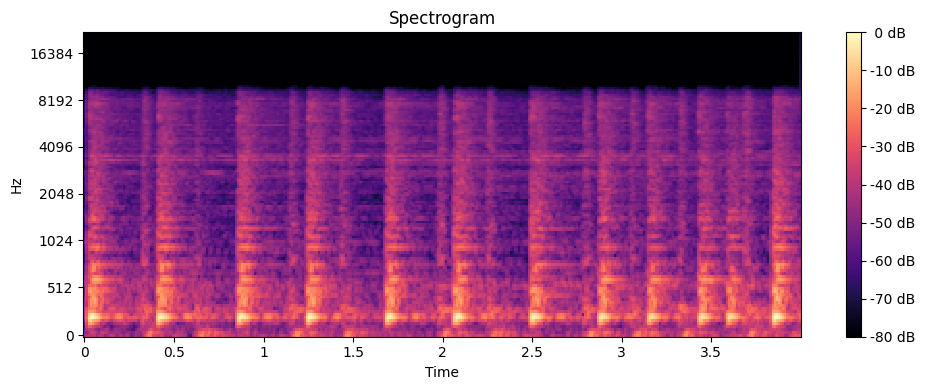

(128, 345)


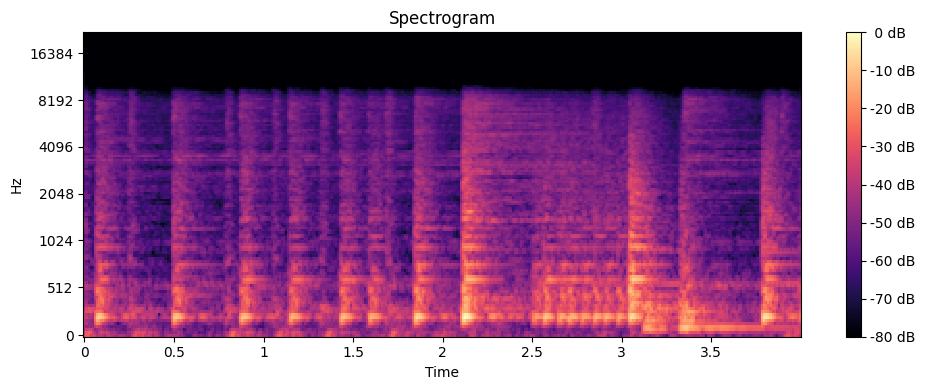

(128, 345)


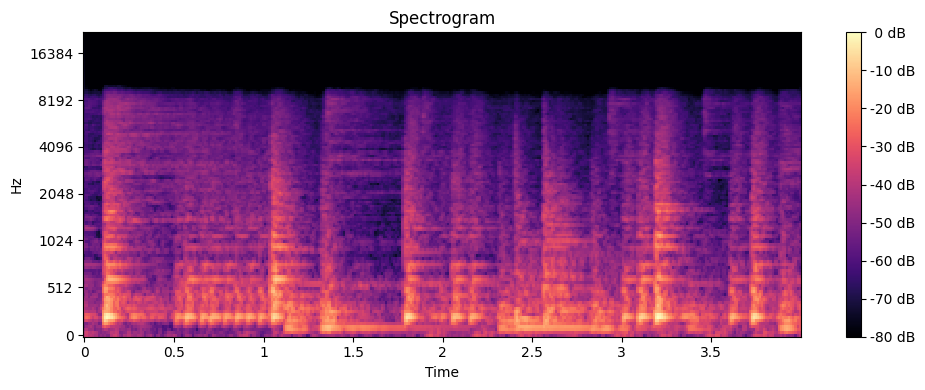

(128, 345)


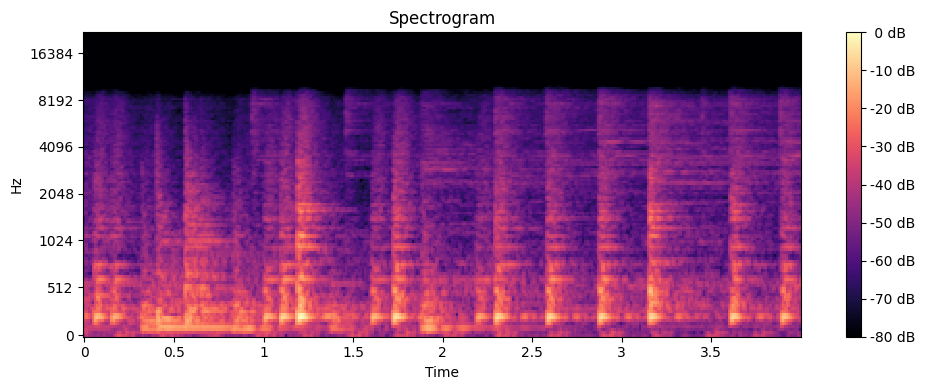

(128, 345)


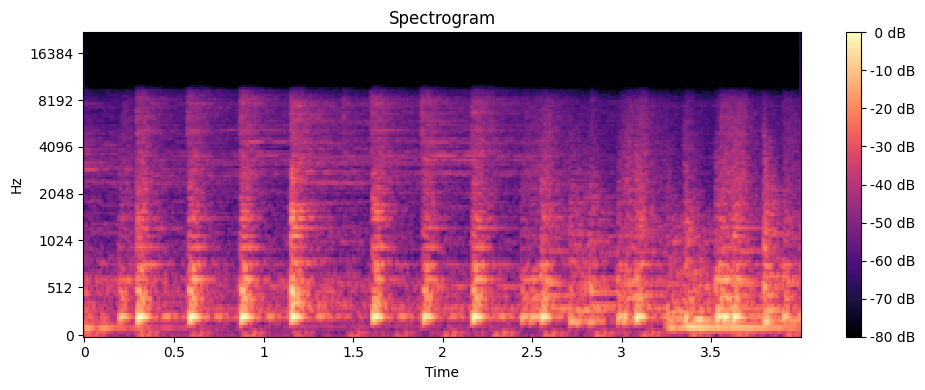

(128, 345)


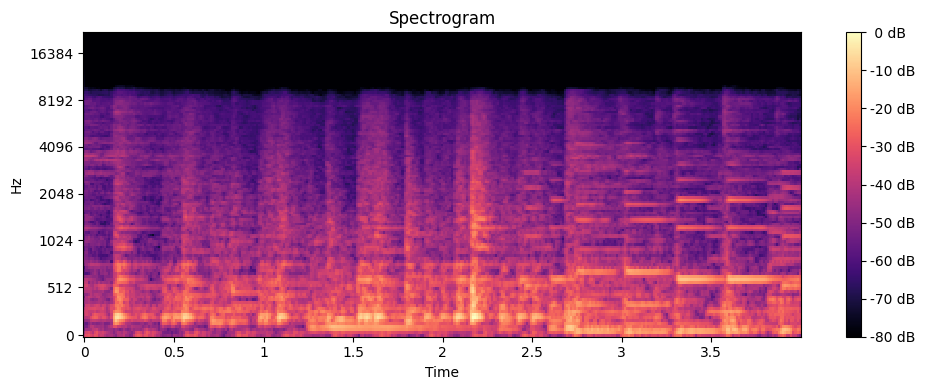

(128, 345)


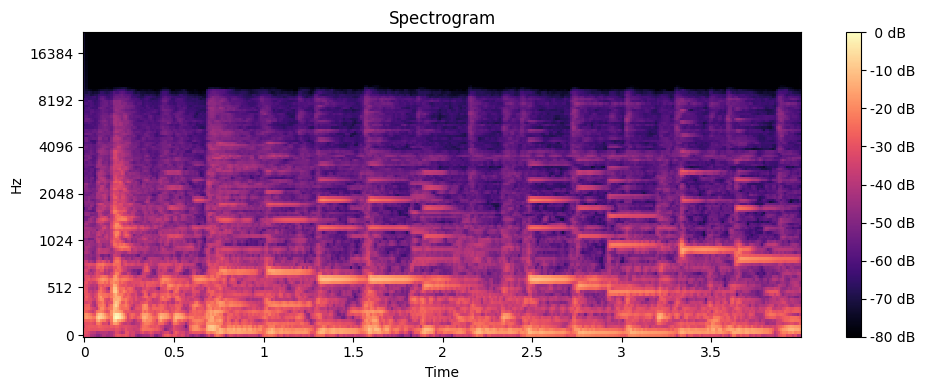

(128, 345)


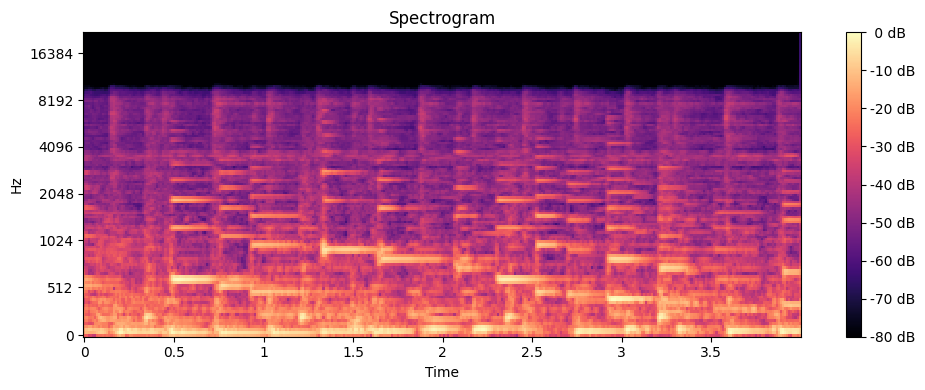

(128, 174)


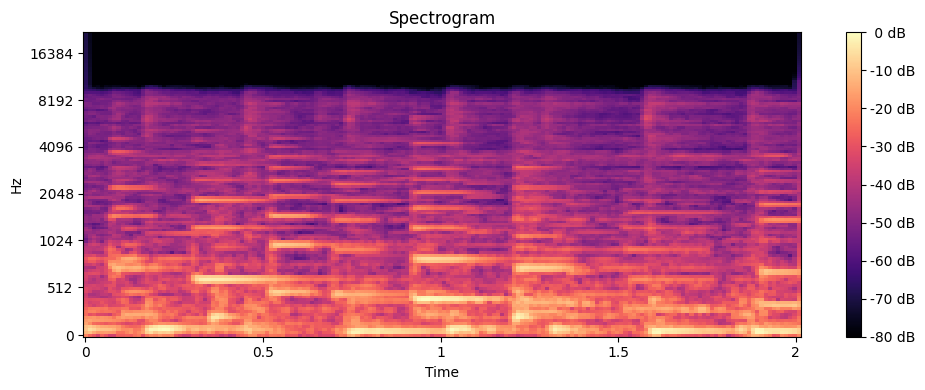

In [15]:
plot_melspectrogram_chunks(y,sr)


#Data Preprocessing

In [16]:
data_dir = DATASET_PATH #"Data/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [17]:
from tensorflow.image import resize
#Load and preprocess audio data
def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                try:
                    audio_data,sample_rate = librosa.load(file_path,sr=None)

                    chunk_duration = 4
                    overlap_duration = 2

                    #Convert duration to sample
                    chunk_samples = chunk_duration * sample_rate
                    overlap_samples = overlap_duration * sample_rate

                    #Calculate the number of chunks
                    num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1

                    #iterate over each chunks
                    for i in range(num_chunks):

                        start = i*(chunk_samples-overlap_samples)
                        end = start+chunk_samples

                        chunk = audio_data[start:end]

                        mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                        #Resize matrix
                        mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                        #Append data to list
                        data.append(mel_spectrogram)
                        labels.append(i_class) # Append only the class index
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    #Return
    return np.array(data),np.array(labels)

In [18]:
data,labels = load_and_preprocess_data(data_dir,classes)
#"D:\1st intern\New folder (4)\genres_original\blues"

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz


/tmp/ipython-input-3570263601.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data,sample_rate = librosa.load(file_path,sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading /content/extracted_data/genres_original/jazz/jazz.00054.wav: 
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [19]:
from tensorflow.keras.utils import to_categorical
# Ensure labels are in the correct shape for one-hot encoding
labels = to_categorical(labels, num_classes=len(classes)) # Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.2,random_state=42)

In [21]:
# X_train = X_train / 255.0
# X_test = X_test / 255.0


In [26]:
model = tf.keras.models.Sequential()

In [29]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.3))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(units=1200,activation='relu'))

model.add(Dropout(0.45))

model.add(Dense(units=len(classes),activation='softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),  # prevent overfitting

#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),

#     layers.Conv2D(128, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.4),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax')  # 10 genres
# ])
# model.summary()
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,066 (18.42 MB)

 Trainable params: 4,829,066 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])


In [32]:
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.1901 - loss: 2.1872 - val_accuracy: 0.3990 - val_loss: 1.6785
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.4209 - loss: 1.6015 - val_accuracy: 0.5716 - val_loss: 1.2261
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.5656 - loss: 1.2474 - val_accuracy: 0.6224 - val_loss: 1.1051
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.6373 - loss: 1.0642 - val_accuracy: 0.7169 - val_loss: 0.8630
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.6978 - loss: 0.8735 - val_accuracy: 0.7412 - val_loss: 0.7548
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.7346 - loss: 0.7851 - val_accuracy: 0.7503 - val_loss: 0.6981
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.7799 - loss: 0.6559 - val_accuracy: 0.7733 - val_loss: 0.6717
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8037 - loss: 0.5727 -

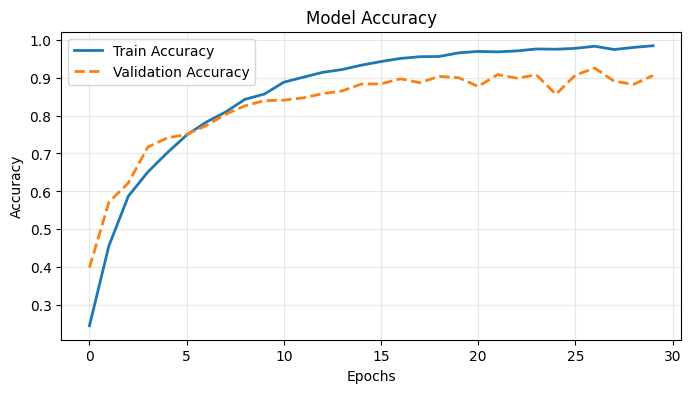

In [47]:
plt.figure(figsize=(8,4))
plt.plot(training_history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


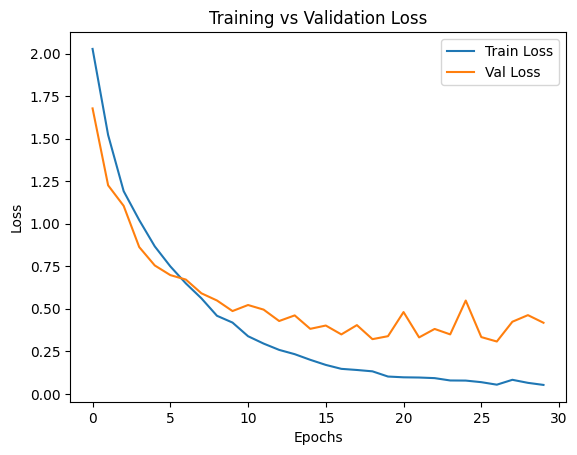

In [50]:
# plt.subplot(1,2,2)
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

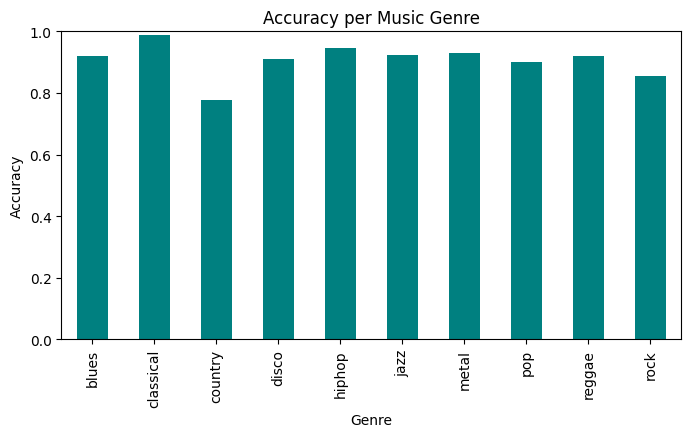

In [45]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

# Convert to DataFrame for plotting
import pandas as pd
df_report = pd.DataFrame(report).transpose()

# Plot class-wise accuracy
df_report.loc[classes, 'recall'].plot(kind='bar', figsize=(8,4), color='teal')
plt.title("Accuracy per Music Genre")
plt.ylabel("Accuracy")
plt.xlabel("Genre")
plt.ylim(0,1)
plt.show()